# Figure 2: Ocean Heat Content non-linear analysis

This notebook will reproduce Figure 2 from *Ocean Heat Content responses to changing Anthropogenic Aerosol Forcing Strength: regional and multi-decadal variability*, E. Boland et al. 2022 ([pre-print](https://doi.org/10.1002/essoar.10511062.3)). This will require utils.py (expects to find it in ../code) and input datafiles (expects to find them in ../data_in) to run - please see the README for details.

The data files loaded were created as follows:
- ohc\_\[exp\]\_\[run\]\_\[basin\].nc from ohc_by_basin_depth.py
- ohc_pic_all_drift.nc from ohc_by_basin_depth_pic.py followed by ohc_pic_drift.py
- volc_aer_absorption_lw.nc courtesy of A Dittus, from the volcanic forcing time series used in the SMURPHS ensemble

Please attribute any plots or code from this notebook using the DOI from Zenodo: [10.5281/zenodo.6418479](https://doi.org/10.5281/zenodo.6418479)

E Boland Nov 2022 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../code/')
import utils
import cftime
from sklearn.decomposition import PCA

In [30]:
# Directories for saving plots and finding input data
figs_dir = '../figs/' # Where you want the plots saved
data_dir='../data_in/' # Where the input data is (see README)

# Experiment info, don't alter
exps=['hist-0p2','hist-0p4','hist-0p7','hist-1p0','hist-1p5']
runs=['r1i1p1f2','r2i1p1f2','r3i1p1f2','r4i1p1f2','r5i1p1f2']
basins=['global','atl','pac','so','ind']
basin_name=dict(zip(basins,['Global','Atlantic','Pacific','Southern','Indian']))
exp_names=['0.2','0.4','0.7','1.0','1.5']
smurphs_cmap= [(255/255, 0 , 0),(255/255 ,165/255,   0),(190/255, 190/255, 190/255),(0   ,0 ,255/255),(160 /255, 32/255 ,240/255)]
Year0=xr.DataArray([1850,1885,1930,1970,2140],dims=['run',],coords={'run':runs})
forc=xr.DataArray(coords={'exp':exps},data=[0.38,0.6,0.93,1.17,1.5],dims=['exp'],)

# Plotting choices
ndegrees = 4 # Order of polynomial fit
filt_val=18 #Number of months for Bworth filter cut-off, used to smooth time series
alpha=0.4

In [31]:
# Load volcanic timeseries and create index by summing over space and wavebands
volc=xr.open_dataset(data_dir+'other_model_data/volc_aer_absorption_lw.nc')
volc=volc.sum(dim=['latitude','model_level_number','waveband'])
abs_index=volc.easy_absorption_lw*0.4/0.015-0.8
abs_index=abs_index[2:]

In [32]:
# Load OHC data
ohc_fd=[]
for basin in basins:
    ohc_temp=[]
    for exp in exps:
        ohc_temp.append(xr.open_mfdataset(data_dir+'ohc_tseries/ohc_'+exp+'*'+basin+'*.nc',concat_dim='run',combine='nested',data_vars=['ohc',], coords='minimal', compat='override'))
    ohc_temp=xr.concat(ohc_temp,'exp',coords='minimal',data_vars=['ohc',]) 
    ohc_fd.append(ohc_temp)
ohc_fd=xr.concat(ohc_fd,'basin',coords='minimal',data_vars=['ohc',],compat='override') 
ohc_fd=ohc_fd.assign_coords(time_days=('time',(ohc_fd.time-ohc_fd.time[0])/np.timedelta64(1,'D')),time_mths=('time',np.arange(0,1980)))

In [33]:
# Load PIC drift
ohc_pic_drift=xr.open_dataarray(data_dir+'pic_data/ohc_pic_all_drift.nc')
ohc_pic_drift=ohc_pic_drift.sel(lev_bins='Full Depth')
ohc_pic_drift['lev_bins']=b'Full Depth'
time_months=xr.DataArray(dims=['time',],data=np.arange(0,1980))
# Offsets at T=0 due to different starting points in the PIC
T0_offset=ohc_fd.ohc.mean(dim='exp').isel(time=0)-ohc_fd.ohc.mean(dim='exp').isel(time=0,run=0)

In [34]:
# De-drift
dplot=ohc_fd.copy()
dplot=dplot-(ohc_pic_drift*1e18*time_months)-(ohc_pic_drift*1e18*(Year0-1850)*12)
dplot=(dplot-dplot.isel(time=slice(0,12*50)).mean(dim=['time','run']))/1e5
dplot=dplot.assign_coords(time_days=('time',(ohc_fd.time-ohc_fd.time[0])/np.timedelta64(1,'D')),time_mths=('time',np.arange(0,1980)))

# Fit a polynomial of degree ndegrees
#polyfit_xr and polyval_xr are vectorised versions of np.polyfit and np.polyval
model_global_poly=utils.polyfit_xr(dplot,ndegrees) 
fit_global_poly=utils.polyval_xr(model_global_poly,dplot.time_days)

# Remove fit to find residual
res_global_poly=dplot.ohc-fit_global_poly
# Smooth residual for plotting
res_global_poly_filt=utils.butter_ufunc(res_global_poly,filt_val,'time')

In [35]:
# PCA analysis of poly fit
pca = PCA(n_components=2)
pca_ds=[]
for basin in basins:
    YY=fit_global_poly.sel(basin=basin).stack({'run_exp':['run','exp']}).chunk({'run_exp': -1})
    pca.fit(YY.data.T)
    evr=pca.explained_variance_ratio_
    pcas=pca.components_
    if pcas[0,-1]<pcas[0,0]: #Have all PCA 1 components increasing for plotting purposes
        pcas[0,:]=-pcas[0,:]
    YYtrans=pca.transform(YY.data.T)
    r2=np.zeros(2)
    p=np.zeros(2)
    for comp in range(0,2):
        stats=utils.new_linregress(np.tile(forc.data,5),YYtrans[:,comp])
        r2[comp]=stats[2]**2
        p[comp]=stats[3]
    pca_ds.append(xr.Dataset(coords={'time':YY.time,'basin':basin},
                      data_vars={'pcas':(('component','time'),pcas),'evr':(('component'),evr),
                                'r2':(('component'),r2),'p_value':(('component'),p),
                                'trans':(('run_exp','component'),YYtrans)}))    
pca_ds=xr.concat(pca_ds,'basin')        

/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/core.py:1514: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/core.py:1514: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/core.py:1514: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future rel

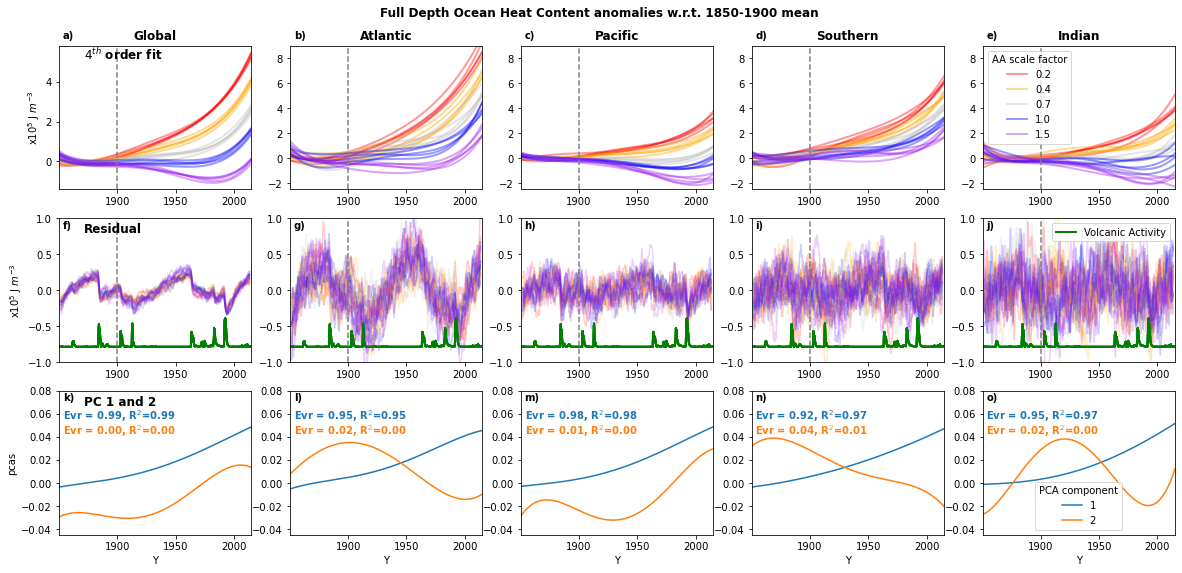

In [40]:
%matplotlib inline
plt.figure(figsize=[20,9])
ax=plt.subplot(2,5,1)
lines=[]
cmap=smurphs_cmap

for ib,basin in enumerate(basins):
    ax_old=ax
    ax=plt.subplot(3,5,1+ib)
    for ie,exp in enumerate(exps):
        line=fit_global_poly.sel(exp=exp,basin=basin).plot(ax=ax,color=cmap[ie],linewidth=2,hue='run',add_legend=False,alpha=alpha)
        lines.append(line[0])
    if ib==0:
        ax.set_ylabel('x10$^{5}$ J $m^{-3}$')
        ax.text(0.13,0.9,'$4^{th}$ order fit',fontweight='bold',fontsize=12,transform=ax.transAxes)
    else:       
        ax.set_ylabel(' ')   
    if ib==4:        
        ax.legend(lines,exp_names,loc='upper left',title='AA scale factor')
    if ib>0:
        ax.set_ylim([-2.5,9])
    ax.set_title(basin_name[basin],{'fontweight':'bold'})
    ax.set_xlabel('')
    ax.text(0.02,1.05,'{})'.format(chr(ord('a')+ib)),fontweight='bold',transform=ax.transAxes)
    ax.set_xlim([dplot.time.sel(time='1850-01-16').data,dplot.time.sel(time='2014-12-16').data])
    plt.axvline(cftime.date2num(cftime.Datetime360Day(1900,1,16),units='days since 2000-01-01',calendar='360_day'),color='grey',ls='--')

lines=[]

for ib,basin in enumerate(basins):
    ax_old=ax
    ax=plt.subplot(3,5,6+ib)
    ax.sharex(ax_old)
    for ie,exp in enumerate(exps):
        for ir,run in enumerate(runs):        
            line=res_global_poly_filt[:,:,:,18:-18].sel(run=run,exp=exp,basin=basin).plot(ax=ax,color=cmap[ie],alpha=alpha/2)  
        lines.append(line[0])
        line_ind=abs_index.plot(x='time',color='g',ax=ax,linewidth=2)
    ax.set_title('')
    if ib == 0:
        ax.set_ylabel('x10$^{5}$ J $m^{-3}$')
        ax.text(0.13,0.9,'Residual',fontweight='bold',fontsize=12,transform=ax.transAxes)   
    else:
        ax.set_ylabel('')
    if ib==4:
        ax.legend([line_ind[0],],['Volcanic Activity',],loc='upper right')
    ax.set_ylim([-1,1])
    ax.set_xlabel('')   
    ax.text(0.02,0.93,'{})'.format(chr(ord('a')+5+ib)),fontweight='bold',transform=ax.transAxes)
    plt.axvline(cftime.date2num(cftime.Datetime360Day(1900,1,16),units='days since 2000-01-01',calendar='360_day'),color='grey',ls='--')
    

lines=[]

for ib,basin in enumerate(basins):
    ax_old=ax
    ax=plt.subplot(3,5,11+ib)
    ax.sharex(ax_old)
    lines.append(pca_ds.pcas.sel(basin=basin).plot(hue='component',add_legend=False,ax=ax))
    ax.set_title('')
    if ib == 0:
        ax.text(0.13,0.9,'PC 1 and 2',fontweight='bold',fontsize=12,transform=ax.transAxes)   
    else:
        ax.set_ylabel('')
    if ib==4:
        ax.legend(['1','2'],title='PCA component')
    ax.set_ylim([-0.045,0.08])
    ax.set_xlabel('Y')   
    for ic in range(0,2):
        ax.text(0.02,0.8-ic*0.1,'Evr = {:2.2f}, R$^2$={:2.2f}'.format(pca_ds.evr.isel(basin=ib,component=ic).data,
                                                      pca_ds.r2.isel(basin=ib,component=ic).data),
           transform=ax.transAxes,fontweight='bold',color=ax.lines[ic].get_color())
    ax.text(0.02,0.93,'{})'.format(chr(ord('a')+10+ib)),fontweight='bold',transform=ax.transAxes)

plt.suptitle('Full Depth Ocean Heat Content anomalies w.r.t. 1850-1900 mean',weight='bold',y=0.94)
plt.savefig(figs_dir+'Fig2_ohc_fd_allruns_detrend'+str(ndegrees)+'th.png',bbox_inches='tight')

Text(0.5, 1.01, 'PC weights for Full Depth Global OHC')

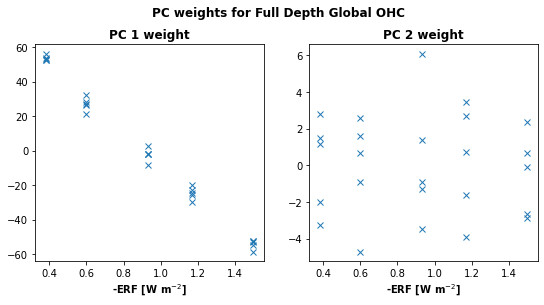

In [41]:
#Example of PC weights against aerosol ERF
plt.figure(figsize=[9,4])
for comp in range(0,2):
    plt.subplot(1,2,comp+1)
    plt.plot(np.tile(forc.data,5),pca_ds['trans'].sel(basin='global').isel(component=comp),'x')
    plt.xlabel('-ERF [W m$^{-2}$]',fontweight='bold')
    plt.title('PC {} weight'.format(comp+1),fontweight='bold')
plt.suptitle('PC weights for Full Depth Global OHC',fontweight='bold',y=1.01)